In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd

In [21]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

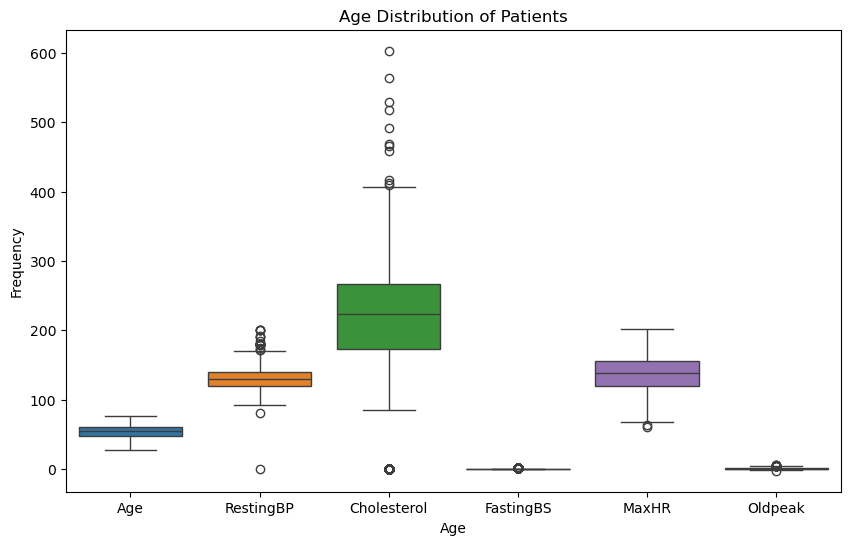

In [22]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('HeartDisease')
display(numeric_cols)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numeric_cols])
plt.title('Age Distribution of Patients')   
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [23]:
# use IQR method cholesterol as an example
col ='Cholesterol'
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
print(f'Number of outliers in {col}: {len(outliers)}')

Number of outliers in Cholesterol: 183


In [24]:

# * Remove Outliers
df_no_outliers = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
print(f'Dataset shape after removing outliers: {df_no_outliers.shape}')

# * Cap outliers
df_capped = df.copy()
df_capped[col]= df_capped[col].clip(lower=lower_bound, upper=upper_bound)

# * Log transformation for skewed data
df_log = df.copy()
df_log[col + "_log"] = np.log(df_log[col]+1)
print(df_log)


Dataset shape after removing outliers: (735, 12)
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_

In [25]:
from sklearn.preprocessing import PolynomialFeatures

# * Polynomial Features using Age and MaxHR 

poly_cols = ['Age', 'MaxHR']
poly = PolynomialFeatures(degree=2,include_bias=False)

poly_features = poly.fit_transform(df[poly_cols])
poly_feature_names = poly.get_feature_names_out(poly_cols)

print(poly_feature_names)
print(poly_features.shape)

['Age' 'MaxHR' 'Age^2' 'Age MaxHR' 'MaxHR^2']
(918, 5)


In [26]:

# * Binning Age into categories (Young, Middle, Old)
df['Age_bin'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Old'])
print(df[['Age', 'Age_bin']])

     Age Age_bin
0     40  Middle
1     49  Middle
2     37  Middle
3     48  Middle
4     54     Old
..   ...     ...
913   45  Middle
914   68     Old
915   57     Old
916   57     Old
917   38  Middle

[918 rows x 2 columns]


In [27]:

# ^ Domain driven risk categories for RestingBP and Oldpeak
def bp_risk(bp):
    if bp < 120:
        return 'Normal'
    elif 120 <= bp < 140:
        return 'Elevated'
    else:
        return 'High'
  

def oldpeak_risk(op):
    if op == 0:
        return "No Stress"
    elif op<2:
        return "Moderate Stress"
    else:
        return "High Stress"
    
df['BP_Risk'] = df['RestingBP'].apply(bp_risk)
df['Oldpeak_Risk'] = df['Oldpeak'].apply(oldpeak_risk)
df[['RestingBP', 'BP_Risk', 'Oldpeak', 'Oldpeak_Risk']].head()


,RestingBP,BP_Risk,Oldpeak,Oldpeak_Risk
0,140,High,0.0,No Stress
1,160,High,1.0,Moderate Stress
2,130,Elevated,0.0,No Stress
3,138,Elevated,1.5,Moderate Stress
4,150,High,0.0,No Stress


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# NOTE Build separate pipeline for numeric and categorical features

# ^ Define numeric and categorical features
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# ^ Numeric Pipeline
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ^ Categorical Pipeline
cat_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

# ^ Combine both pipelines using ColumnTransformer
preprocess = ColumnTransformer(
  [
      ('num',num_pipeline,numeric_features),
      ('cat',cat_pipeline,categorical_features)
  ]
)

# ^ Full pipeline with a simple model
clf = Pipeline([
    ('prep',preprocess)
    ,('model',LogisticRegression(max_iter=1000))
])


